num of inliners: 39 average residual: 0.284815968128475
num of inliers shown in the matching: 39


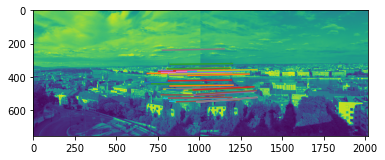

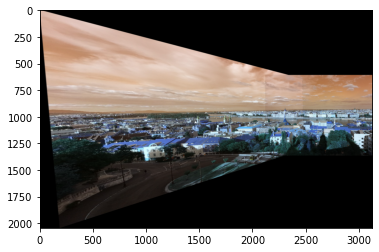

In [5]:
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import random
import skimage
import scipy
from PIL import Image
import numpy as np
import skimage
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance
import scipy
import skimage.io
import random
import skimage.transform
from PIL import Image

def readimg(dirs, imgname):
    img = cv2.imread(dirs + imgname)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img

def readimg_color(dirs, imgname):
    img = cv2.imread(dirs + imgname)
    img = cv2.normalize(img.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    return img

def sift_descriptor(img):
    sift = cv2.SIFT_create()
    kp, dsp = sift.detectAndCompute(img, None)

    return kp, dsp

def show_sift(kp, img):
    # show the img with descriptors
    copyimg = img.copy()
    copyimg = cv2.drawKeypoints(img, kp, copyimg)
    plt.imshow(copyimg)
    plt.show()

def calculate_distance(kp1, kp2, dsp1, dsp2, num_threshold):
    # fast computation of Euclidean distance between each descriptors
    dist = scipy.spatial.distance.cdist(dsp1, dsp2, 'sqeuclidean')
    # find the matching coordinates
    idx1 = np.where(dist < num_threshold)[0]
    idx2 = np.where(dist < num_threshold)[1]
    coord1 = np.array([kp1[idx].pt for idx in idx1])
    coord2 = np.array([kp2[idx].pt for idx in idx2])
    # put into pairs of coords
    match_coords = np.concatenate((coord1, coord2), axis=1)

    return match_coords

def get_errors(matches, H):
	# difference between original img2 points and transformed img1 points with H
    num_pairs = len(matches)
    # all matching points in img1
    p1 = np.concatenate((matches[:, 0:2], np.ones((1, num_pairs)).T), axis=1)
    # all matching points in img2
    p2 = matches[:, 2:4]

    # Transform every point in p1 to estimate p2.
    transformed_p1 = np.zeros((num_pairs, 2))
    for i in range(num_pairs):
        transformed_p1[i] = (np.matmul(H, p1[i]) / np.matmul(H, p1[i])[-1])[0:2]

    # Compute error of each matching pair
    errors = np.linalg.norm(p2 - transformed_p1, axis=1) ** 2
    return errors

def compute_H(subset):
    # calculate the fitted homography
    A = []

    for i in range(subset.shape[0]):
        p1 = np.append(subset[i][0:2], 1)
        p2 = np.append(subset[i][2:4], 1)
        
        row1 = [0, 0, 0, p1[0], p1[1], p1[2], -p2[1]*p1[0], -p2[1]*p1[1], -p2[1]*p1[2]]
        row2 = [p1[0], p1[1], p1[2], 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1], -p2[0]*p1[2]]
        A.append(row1)
        A.append(row2)

    A = np.array(A)

    U, s, V = np.linalg.svd(A)
    H = V[len(V)-1].reshape(3, 3)

    # normalize
    H = H / H[2, 2]
    return H

def show_inlier_matches(img1, img2, inliers):
    print("num of inliers shown in the matching: " + str(len(inliers)))
    h1, w1 = img1.shape
    h2, w2 = img2.shape

    vis = np.zeros((max(h1, h2), w1 + w2), np.uint8)
    vis[:, :w1] = img1
    vis[:h2, w1:] = img2

    fig, ax = plt.subplots()
    ax.imshow(vis)
    ax.plot([inliers[:,0], inliers[:,2] + w1],[inliers[:,1], inliers[:,3]])
    plt.show()

def ransac(img1, img2, matches, thres_ransac):
    itertimes = 1000
    inliners = 0
    max_inliners = 0

    for iter in range(0, itertimes):
        subset_idx = random.sample(range(matches.shape[0]), k=4)
        subset = matches[subset_idx]

        H = compute_H(subset)

        # check if it is full rank
        if np.linalg.matrix_rank(H) < 3:
            continue

        # the norm of error caused if we choose the above subset
        errors = get_errors(matches, H)
        idx = np.where(errors < thres_ransac)[0]
        inlinerspts = matches[idx]

        # find the best number of inliners 
        inliners = len(inlinerspts)
        if inliners >= max_inliners:
            which_inliners = inlinerspts.copy()
            max_inliners = inliners
            best_H = H.copy()
            
            avg_residual = sum(get_errors(matches[idx], H)) / inliners

    print("num of inliners: " + str(max_inliners) + " average residual: " + str(avg_residual))
    show_inlier_matches(img1, img2, which_inliners)
    return best_H

# function provided by Maghav at Piazza @450
def warp_images(image0, image1, H):
    transform = skimage.transform.ProjectiveTransform(H)
    warp = skimage.transform.warp

    r, c = image1.shape[:2]
    # Note that transformations take coordinates in (x, y) format,
    # not (row, column), in order to be consistent with most literature
    corners = np.array([[0, 0],
                        [0, r],
                        [c, 0],
                        [c, r]])

    # Warp the image corners to their new positions
    warped_corners = transform(corners)

    # Find the extents of both the reference image and the warped
    # target image
    all_corners = np.vstack((warped_corners, corners))

    corner_min = np.min(all_corners, axis=0)
    corner_max = np.max(all_corners, axis=0)

    output_shape = (corner_max - corner_min)
    output_shape = np.ceil(output_shape[::-1])

    offset = skimage.transform.SimilarityTransform(translation=-corner_min)

    image0_ = warp(image0, offset.inverse, output_shape=output_shape, cval=-1)

    image1_ = warp(image1, (transform + offset).inverse, output_shape=output_shape, cval=-1)

    image0_zeros = warp(image0, offset.inverse, output_shape=output_shape, cval=0)

    image1_zeros = warp(image1, (transform + offset).inverse, output_shape=output_shape, cval=0)

    overlap = (image0_ != -1.0 ).astype(int) + (image1_ != -1.0).astype(int)
    overlap += (overlap < 1).astype(int)
    merged = (image0_zeros+image1_zeros)/overlap

    im = Image.fromarray((255*merged).astype('uint8'), mode='RGB')
    im = np.asarray(im)

    return im

def main(leftimg, rightimg, leftimgcolor, rightimgcolor):
    # using 7000, 0.5 for 2 pic; 9000, 1.0 for 3 pic
    thres = 9000
    thres_ransac = 1.0

    kp1, dsp1 = sift_descriptor(leftimg)
    kp2, dsp2 = sift_descriptor(rightimg)

    # get all matching points
    matches = calculate_distance(kp1, kp2, dsp1, dsp2, thres)

    H_matrix = ransac(leftimg, rightimg, matches, thres_ransac)

    stitched_img = warp_images(rightimgcolor, leftimgcolor, H_matrix)

    return stitched_img

def main_2pic():
#     dirs = 'MP3_part1_data/' + 'park/'
#     leftimg = readimg(dirs, 'left.jpg')
#     rightimg = readimg(dirs, 'right.jpg')
#     leftimgcolor = readimg_color(dirs, 'left.jpg')
#     rightimgcolor = readimg_color(dirs, 'right.jpg')
    dirs = "./stitch/"
    leftimg = readimg(dirs, 'left.jpg')
    rightimg = readimg(dirs, 'right.jpg')
    leftimgcolor = readimg_color(dirs, 'left.jpg')
    rightimgcolor = readimg_color(dirs, 'right.jpg')

    stitched_img = main(leftimg, rightimg, leftimgcolor, rightimgcolor)

    plt.imshow(stitched_img)
    plt.show()

# def main_3pic():
#     dirs = 'MP3_part1_data/' + 'pier/' # ledge pier hill
#     leftimg = readimg(dirs, '1.jpg')
#     midimg = readimg(dirs, '2.jpg')
#     rightimg = readimg(dirs, '3.jpg')
#     leftimgcolor = readimg_color(dirs, '1.jpg')
#     midimgcolor = readimg_color(dirs, '2.jpg')
#     rightimgcolor = readimg_color(dirs, '3.jpg')

#     stitched1 = main(leftimg, midimg, leftimgcolor, midimgcolor)

#     plt.imshow(stitched1)
#     plt.show()

#     grey_stitch1 = cv2.cvtColor(stitched1, cv2.COLOR_RGB2GRAY)

#     stitched2 = main(grey_stitch1, rightimg, stitched1, rightimgcolor)

#     plt.imshow(stitched2)
#     plt.show()

if __name__ == '__main__':
    main_2pic()
